In [202]:
import collections
import cProfile
import hashlib
import itertools
import os
import pstats
import string
import re

from datetime import datetime
from io import StringIO
from tqdm.notebook import tqdm as tqdm

import torch
import torchaudio
from torch import nn, topk
from torch.optim import Adadelta
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS, LIBRISPEECH
from torchaudio.transforms import MFCC

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [203]:
audio_backend = "soundfile"
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers = 0
pin_memory = False
non_blocking = pin_memory

excluded_dir = ["_background_noise_"]
folder_speechcommands = './SpeechCommands/speech_commands_v0.02'

char_null = "-"
char_pad = " "
# labels = [char_null, char_pad] + [d for d in next(os.walk(folder_speechcommands))[1] if d not in excluded_dir]
labels = [char_null + char_pad + string.ascii_lowercase]

# vocab_size = len(labels) + 2
shuffle = True
drop_last = True

# audio, self.sr, window_stride=(160, 80), fft_size=512, num_filt=20, num_coeffs=13
n_mfcc = 13
melkwargs = {
    'n_fft': 512,
    'n_mels': 20,
    'hop_length': 80,
}
sample_rate = 16000

# max number of sentences per batch
batch_size = 2048
# batch_size = 32
optimizer_params = {
    "lr": 1.0,
    "eps": 1e-8,
    "rho": 0.95,
    "weight_decay": .1,
}

# hidden_size = 128
# num_layers = 3
hidden_size = 8
num_layers = 1

max_epoch = 200
mod_epoch = 10
clip_norm = 0.  # 10.
zero_infinity = False

training_percentage = 80.
validation_percentage = 10.
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

print_length = 20

dtstamp = datetime.now().strftime("%y%m%d.%H%M%S")
print(dtstamp)

num_devices = torch.cuda.device_count()
print(num_devices, "GPUs")

200302.134801
2 GPUs


In [204]:
torch.cuda.empty_cache()

# Profiling performance
pr = cProfile.Profile()
pr.enable()

torchaudio.set_audio_backend(audio_backend)
mfcc = MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc, melkwargs=melkwargs).to(device)

# Text encoding

In [205]:
class Coder:
    def __init__(self, labels):
        labels = list(collections.OrderedDict.fromkeys(list("".join(labels))))
        self.length = len(labels)
        enumerated = list(enumerate(labels))
        flipped = [(sub[1], sub[0]) for sub in enumerated]

        d1 = collections.OrderedDict(enumerated)
        d2 = collections.OrderedDict(flipped)
        self.mapping = {**d1, **d2}

    def _map(self, iterable):
        # iterable to iterable
        return [self.mapping[i] for i in iterable]

    def encode(self, iterable):
        if isinstance(iterable[0], list):
            return [self.encode(i) for i in iterable]
        else:
            return self._map(iterable)

    def decode(self, tensor):
        if isinstance(tensor[0], list):
            return [self.decode(t) for t in tensor]
        else:
            return "".join(self._map(tensor))


coder = Coder(labels)
encode = coder.encode
decode = coder.decode
vocab_size = coder.length

# Dataset

In [206]:
class IterableMemoryCache:
    def __init__(self, iterable):
        self.iterable = iterable
        self.iter = iter(iterable)
        self.done = False
        self.vals = []

    def __iter__(self):
        if self.done:
            return iter(self.vals)
        # chain vals so far & then gen the rest
        return itertools.chain(self.vals, self._gen_iter())

    def _gen_iter(self):
        # gen new vals, appending as it goes
        for new_val in self.iter:
            self.vals.append(new_val)
            yield new_val
        self.done = True

    def __len__(self):
        return len(self.iterable)


class MapMemoryCache(torch.utils.data.Dataset):
    """
    Wrap a dataset so that, whenever a new item is returned, it is saved to memory.
    """

    def __init__(self, dataset):
        self.dataset = dataset
        self._id = id(self)
        self._cache = [None] * len(dataset)

    def __getitem__(self, n):
        if self._cache[n]:
            return self._cache[n]

        item = self.dataset[n]
        self._cache[n] = item

        return item

    def __len__(self):
        return len(self.dataset)

In [207]:
# @torch.jit.script
def process_datapoint(item):
    transformed = item[0].to(device, non_blocking=non_blocking)
    target = item[2].lower()
    # target = "".join(filter(str.isalnum, target))
    target = "".join(c for c in target if c.isalnum() or c == char_pad)
    # pick first channel, apply mfcc, tranpose for pad_sequence
    transformed = mfcc(transformed)
    transformed = transformed[0, ...].transpose(0, -1)
    # transformed = transformed.view(-1, 1)
    target = encode(target)
    target = torch.tensor(target, dtype=torch.long, device=transformed.device)
    return transformed, target


class PROCESSED_LIBRISPEECH(LIBRISPEECH):

    def __getitem__(self, n):
        try:
            item = super().__getitem__(n)
            return process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return None

    def __next__(self):
        try:
            item = super().__next__()
            return process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return self.__next__()


def datasets():
    root = "./"

    training = PROCESSED_LIBRISPEECH(root, url="train-clean-100", download=True)
    training = MapMemoryCache(training)
    validation = PROCESSED_LIBRISPEECH(root, url="dev-clean", download=True)
    validation = MapMemoryCache(validation)

    return training, validation, None

In [208]:
def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
        filename: File path of the data sample.
        validation_percentage: How much of the data set to use for validation.
        testing_percentage: How much of the data set to use for testing.

    Returns:
        String, one of 'training', 'validation', or 'testing'.
    """
    base_name = os.path.basename(filename)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name).encode("utf-8")
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) % (MAX_NUM_WAVS_PER_CLASS + 1)) * (100.0 / MAX_NUM_WAVS_PER_CLASS))
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'
    return result


class FILTERED_SPEECHCOMMANDS(SPEECHCOMMANDS):
    def __init__(self, tag, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if training_percentage < 100.:
            testing_percentage = (100. - training_percentage - validation_percentage)
            self._walker = list(filter(lambda x: which_set(x, validation_percentage, testing_percentage) == tag, self._walker))


# @torch.jit.script
def process_datapoint(item):
    transformed = item[0].to(device, non_blocking=non_blocking)
    target = item[2]
    # pick first channel, apply mfcc, tranpose for pad_sequence
    transformed = mfcc(transformed)
    transformed = transformed[0, ...].transpose(0, -1)
    # transformed = transformed.view(-1, 1)
    target = encode(target)
    target = torch.tensor(target, dtype=torch.long, device=transformed.device)
    return transformed, target


class PROCESSED_SPEECHCOMMANDS(FILTERED_SPEECHCOMMANDS):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, n):
        item = super().__getitem__(n)
        return process_datapoint(item)

    def __next__(self):
        item = super().__next__()
        return process_datapoint(item)


def datasets():
    root = "./"

    training = PROCESSED_SPEECHCOMMANDS("training", root, download=True)
    training = MapMemoryCache(training)
    validation = PROCESSED_SPEECHCOMMANDS("validation", root, download=True)
    validation = MapMemoryCache(validation)
    testing = PROCESSED_SPEECHCOMMANDS("testing", root, download=True)
    testing = MapMemoryCache(testing)

    return training, validation, testing

In [209]:
def collate_fn(batch):

    tensors = [b[0] for b in batch if b]
    targets = [b[1] for b in batch if b]

    # input_lengths = [t.shape[0] for t in tensors]
    # target_lengths = [len(t) for t in targets]

    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.transpose(1, -1)

    return tensors, targets  # , input_lengths, target_lengths

# Model

[Wav2Letter](https://github.com/LearnedVector/Wav2Letter/blob/master/Google%20Speech%20Command%20Example.ipynb)

In [210]:
class PrintLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x)
        return x
    

class Wav2Letter(nn.Module):
    """Wav2Letter Speech Recognition model
        https://arxiv.org/pdf/1609.03193.pdf
        This specific architecture accepts mfcc or power spectrums speech signals

        Args:
            num_features (int): number of mfcc features
            num_classes (int): number of unique grapheme class labels
    """

    def __init__(self, num_features, num_classes):
        super().__init__()

        # Conv1d(in_channels, out_channels, kernel_size, stride)
        self.layers = nn.Sequential(
            # PrintLayer(),
            nn.Conv1d(num_features, 250, 48, 2),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            nn.Conv1d(250, 2000, 32),
            nn.ReLU(),
            nn.Conv1d(2000, 2000, 1),
            nn.ReLU(),
            nn.Conv1d(2000, num_classes, 1),
        )

    def forward(self, batch):
        """Forward pass through Wav2Letter network than
            takes log probability of output
        Args:
            batch (int): mini batch of data
            shape (batch, num_features, frame_len)
        Returns:
            Tensor with shape (batch_size, num_classes, output_len)
        """
        # print(batch.shape)
        # y_pred shape (batch_size, num_classes, output_len)
        y_pred = self.layers(batch)

        # compute log softmax probability on graphemes
        log_probs = nn.functional.log_softmax(y_pred, dim=1)
        log_probs = log_probs.transpose(1, 2)
        return log_probs


class BiLSTM(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.directions = 2
        # self.layer = nn.GRU(num_features, hidden_size, num_layers=3, batch_first=True, bidirectional=True)
        # self.layer = nn.LSTM(num_features, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # https://discuss.pytorch.org/t/lstm-to-bi-lstm/12967
        self.layer = nn.LSTM(num_features, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.hidden2class = nn.Linear(self.directions*hidden_size, num_classes)
        
        # https://discuss.pytorch.org/t/lstm-dataparallel-hidden-state-not-split-between-workers/43630
        # https://discuss.pytorch.org/t/when-to-initialize-lstm-hidden-state/2323/2
        # https://discuss.pytorch.org/t/dynamic-parameter-declaration-in-forward-function/427
        h0, h1 = self.init_hidden()
        self.register_parameter('hidden0', torch.nn.Parameter(h0))
        self.register_parameter('hidden1', torch.nn.Parameter(h1))
        
        # self.hidden = None

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return (torch.zeros(self.directions*num_layers, batch_size//num_devices, hidden_size).cuda(),
                torch.zeros(self.directions*num_layers, batch_size//num_devices, hidden_size).cuda())

    def forward(self, inputs):
        # https://github.com/pytorch/pytorch/issues/21108
        # https://discuss.pytorch.org/t/rnn-module-weights-are-not-part-of-single-contiguous-chunk-of-memory/6011/21
        if self.training:
            self.lstm.flatten_parameters()        

        inputs = inputs.transpose(-1, -2).contiguous()
        outputs, hidden = self.layer(inputs, (self.hidden0, self.hidden1))
        self.hidden0 = torch.nn.Parameter(hidden[0].detach())
        self.hidden1 = torch.nn.Parameter(hidden[1].detach())

        outputs = self.hidden2class(outputs)

        log_probs = nn.functional.log_softmax(outputs, dim=1)
        return log_probs

# Word Decoder

In [211]:
def greedy_decoder(outputs):
    """Greedy Decoder. Returns highest probability of class labels for each timestep

    Args:
        outputs (torch.Tensor): shape (input length, batch size, number of classes (including blank))

    Returns:
        torch.Tensor: class labels per time step.
    """
    _, indices = topk(outputs, k=1, dim=-1)
    return indices[..., 0]

# Train

In [212]:
# model = Wav2Letter(n_mfcc, vocab_size)
# model = BiLSTM(1, vocab_size)
model = BiLSTM(n_mfcc, vocab_size)

In [213]:
training, validation, _ = datasets()
loader_training = DataLoader(
    training, batch_size=batch_size, collate_fn=collate_fn, shuffle=shuffle, drop_last=drop_last,
    num_workers=num_workers, pin_memory=pin_memory,
)
loader_validation = DataLoader(
    validation, batch_size=batch_size, collate_fn=collate_fn, shuffle=False, drop_last=drop_last,
    num_workers=num_workers, pin_memory=pin_memory,
)

# model = torch.jit.script(model)

model = nn.DataParallel(model, [0,1]) if num_devices > 1 else model

model = model.to(device, non_blocking=non_blocking)

optimizer = Adadelta(model.parameters(), **optimizer_params)
criterion = torch.nn.CTCLoss(zero_infinity=zero_infinity)

best_loss = 1.

In [214]:
def forward_and_loss(inputs, targets):

    inputs = inputs.to(device, non_blocking=non_blocking)
    targets = targets.to(device, non_blocking=non_blocking)
    outputs = model(inputs).transpose(0, 1)

    this_batch_size = outputs.shape[1]
    input_lengths = torch.full(
        (this_batch_size,), outputs.shape[0], dtype=torch.long, device=outputs.device
    )
    target_lengths = torch.tensor(
        [target.shape[0] for target in targets], dtype=torch.long, device=targets.device
    )
    
    # CTC
    # https://pytorch.org/docs/master/nn.html#torch.nn.CTCLoss
    # https://discuss.pytorch.org/t/ctcloss-with-warp-ctc-help/8788/3
    
    # outputs: input length, batch size, number of classes (including blank)
    # targets: batch size, max target length
    # input_lengths: batch size
    # target_lengths: batch size

    return criterion(outputs, targets, input_lengths, target_lengths)


def forward_and_decode(inputs, targets):
    output = model(inputs).transpose(0, 1)
    output = output[:, 0, :]
    output = greedy_decoder(output)
    output = decode(output.tolist())
    target = decode(targets.tolist()[0])

    output = output.ljust(print_length)[:print_length]
    target = target.ljust(print_length)[:print_length]
    return f"Epoch: {epoch:4}   Target: {target}   Output: {output}"

In [216]:
sum_loss_training = []
sum_loss_validation = []

for epoch in tqdm(range(max_epoch)):

    model.train()

    sum_loss = 0.
    for inputs, targets in loader_training:

        loss = forward_and_loss(inputs, targets)
        sum_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        if clip_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()

    # Average loss
    sum_loss = sum_loss / len(loader_training)
    sum_loss_training.append((epoch, sum_loss))
    sum_loss_str = f"Epoch: {epoch:4}   Train: {sum_loss:4.5f}"
        
    with torch.no_grad():

        if not epoch % mod_epoch:
            
            # Switch to evaluation mode
            model.eval()
        
            print(forward_and_decode(inputs, targets))

            sum_loss = 0.
            for inputs, targets in loader_validation:

                loss = forward_and_loss(inputs, targets)
                sum_loss += loss.item()

            # Average loss
            sum_loss = sum_loss / len(loader_validation)
            sum_loss_validation.append((epoch, sum_loss))
            sum_loss_str += f"   Validation: {sum_loss:.5f}"

            print(forward_and_decode(inputs, targets))

            print(sum_loss_str)

            if sum_loss < best_loss:
                # Save model
                torch.save(model.state_dict(), f"./model.{dtstamp}.{epoch}.ph")
                best_loss = sum_loss


Epoch:    0   Target: two-----               Output: sslllllsssssssssssss


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:    0   Target: nine----               Output: vlllhhyyyyyyunnnnnnn
Epoch:    0   Train: 125.21604   Validation: 159.68492


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:   10   Target: zero----               Output: eeeeeeeeeeeeeeeeeeee


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:   10   Target: nine----               Output: wwwww---llrrrrssrooo
Epoch:   10   Train: 120.74454   Validation: 153.93000


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:   20   Target: backward               Output: rr------rrrrr-------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:   20   Target: nine----               Output: --------------------
Epoch:   20   Train: 122.42014   Validation: 156.55819


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:   30   Target: go------               Output: -----eeeeeeeeeeeeeee


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:   30   Target: nine----               Output: -----eeeeeeeeeeeeeee
Epoch:   30   Train: 126.50077   Validation: 161.94755


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:   40   Target: zero----               Output: ---eeeeeeeeeeeeeeeee


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:   40   Target: nine----               Output: ---eeeeeeeeeeeeeeeee
Epoch:   40   Train: 126.50078   Validation: 161.94756


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:   50   Target: off-----               Output: ---eeeeeeeeeeeeeeeee


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:   50   Target: nine----               Output: ---eeeeeeeeeeeeeeeee
Epoch:   50   Train: 126.50078   Validation: 161.94756


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:   60   Target: two-----               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:   60   Target: nine----               Output: --------------------
Epoch:   60   Train: 126.50077   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:   70   Target: stop----               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:   70   Target: nine----               Output: --------------------
Epoch:   70   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:   80   Target: seven---               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:   80   Target: nine----               Output: --------------------
Epoch:   80   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:   90   Target: off-----               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:   90   Target: nine----               Output: --------------------
Epoch:   90   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:  100   Target: left----               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:  100   Target: nine----               Output: --------------------
Epoch:  100   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:  110   Target: no------               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:  110   Target: nine----               Output: --------------------
Epoch:  110   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:  120   Target: right---               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:  120   Target: nine----               Output: --------------------
Epoch:  120   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:  130   Target: forward-               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:  130   Target: nine----               Output: --------------------
Epoch:  130   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:  140   Target: six-----               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:  140   Target: nine----               Output: --------------------
Epoch:  140   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:  150   Target: nine----               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:  150   Target: nine----               Output: --------------------
Epoch:  150   Train: 126.50077   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:  160   Target: nine----               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:  160   Target: nine----               Output: --------------------
Epoch:  160   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:  170   Target: four----               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:  170   Target: nine----               Output: --------------------
Epoch:  170   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:  180   Target: nine----               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:  180   Target: nine----               Output: --------------------
Epoch:  180   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



Epoch:  190   Target: yes-----               Output: --------------------


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Epoch:  190   Target: nine----               Output: --------------------
Epoch:  190   Train: 126.50078   Validation: 161.94757


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


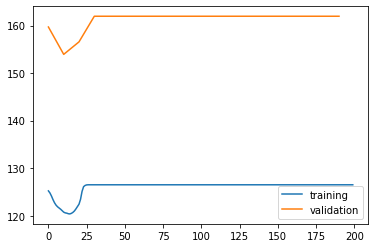

In [217]:
plt.plot(*zip(*sum_loss_training), label="training")
plt.plot(*zip(*sum_loss_validation), label="validation")

plt.legend()
plt.show()

In [218]:
# Save model
torch.save(model.state_dict(), f"./model.{dtstamp}.{epoch}.ph")

# Print performance
pr.disable()
s = StringIO()
ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime").print_stats(20)
print(s.getvalue())

         215366514 function calls (212989220 primitive calls) in 2225.727 seconds

   Ordered by: cumulative time
   List reduced from 2403 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       23    0.001    0.000 2225.712   96.770 base_events.py:1686(_run_once)
      145    0.000    0.000 1514.966   10.448 events.py:86(_run)
      145    0.000    0.000 1514.966   10.448 {method 'run' of 'Context' objects}
       90    0.000    0.000 1514.964   16.833 ioloop.py:735(_run_callback)
    57/15    0.000    0.000 1514.963  100.998 gen.py:716(run)
    89/33    0.000    0.000 1514.962   45.908 {method 'send' of 'generator' objects}
       13    0.000    0.000 1514.960  116.535 ioloop.py:690(<lambda>)
       13    0.000    0.000 1514.960  116.535 gen.py:784(inner)
    67/24    0.001    0.000 1514.959   63.123 gen.py:184(wrapper)
       57    0.000    0.000 1514.957   26.578 kernelbase.py:347(process_one)
       34    0.001    0.000 1514.9

* Data parallel with initialization and LSTM
* zero_infinity